In [1]:
import sys
import pickle
import scipy.io as sio
import numpy as np
import keras.backend as K
from keras.optimizers import SGD
from keras.utils import np_utils
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement

Using TensorFlow backend.
/Users/dwright/anaconda2/envs/aind/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
sys.path.insert(0,'/Users/dwright/dev/zoo/machine_augmented_classification/experiments/dissolving/mutitask/snhunters')
from multitask_experiment import MultitaskDEC

/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
sys.path.insert(0,'/Users/dwright/dev/zoo/machine_augmented_classification/experiments/dissolving')
from dissolving_utils import get_cluster_centres, get_cluster_to_label_mapping
from dissolving_utils import pca_plot

In [4]:
sys.path.insert(0,'/Users/dwright/dev/zoo/machine_augmented_classification/DEC-keras')
from DEC import DEC

In [5]:
from sklearn.metrics import f1_score, roc_curve, homogeneity_score, normalized_mutual_info_score

In [6]:
def all_same(items):
  return all(x == items[0] for x in items)

In [7]:
def get_best_mapping(y, predicted_clusters, n_clusters, fom):
  best_metric = 0
  best_mapping = []
  for cluster_to_label_mapping in combinations_with_replacement([0,1], n_clusters):
    if all_same(cluster_to_label_mapping):
      continue
    metric = fom(y, predicted_clusters, cluster_to_label_mapping)
    if metric >= best_metric:
      best_metric = metric
      best_mapping = cluster_to_label_mapping
  return best_metric, best_mapping

In [8]:
def calc_f1_score(y_true, predicted_clusters, cluster_to_label_mapping):
  y_pred = []
  for i in range(len(y_true)):
    y_pred.append(cluster_to_label_mapping[predicted_clusters[i]])
  return f1_score(y_true, np.array(y_pred))

In [9]:
def one_percent_fpr(y, pred, fom):
    fpr, tpr, thresholds = roc_curve(y, pred)
    FoM = 1-tpr[np.where(fpr<=fom)[0][-1]] # MDR at 1% FPR
    threshold = thresholds[np.where(fpr<=fom)[0][-1]]
    return FoM, threshold, fpr, tpr

In [10]:
def get_cluster_to_label_mapping_safe(y, y_pred, n_classes, n_clusters, toprint=True):
  """Enusre at least one cluster assigned to each label.
  """
  one_hot_encoded = np_utils.to_categorical(y, n_classes)

  cluster_to_label_mapping = []
  n_assigned_list = []
  majority_class_fractions = []
  majority_class_pred = np.zeros(y.shape)
  for cluster in range(n_clusters):
    cluster_indices = np.where(y_pred == cluster)[0]
    n_assigned_examples = cluster_indices.shape[0]
    n_assigned_list.append(n_assigned_examples)
    cluster_labels = one_hot_encoded[cluster_indices]
    cluster_label_fractions = np.mean(cluster_labels, axis=0)
    majority_cluster_class = np.argmax(cluster_label_fractions)
    cluster_to_label_mapping.append(majority_cluster_class)
    majority_class_pred[cluster_indices] += majority_cluster_class
    majority_class_fractions.append(cluster_label_fractions[majority_cluster_class])
    if toprint:
      print(cluster, n_assigned_examples, majority_cluster_class, cluster_label_fractions[majority_cluster_class])
  #print(cluster_to_label_mapping)
  if toprint:
    print(np.unique(y), np.unique(cluster_to_label_mapping))
  try:
    # make sure there is at least 1 cluster representing each class
    assert np.all(np.unique(y) == np.unique(cluster_to_label_mapping))
  except AssertionError:
    # if there is no cluster for a class then we will assign a cluster to that
    # class
    
    # find which class it is
    # ASSUMPTION - this task is binary
    
    diff = list(set(np.unique(y)) - set(np.unique(cluster_to_label_mapping)))[0]
      # we choose the cluster that contains the most examples of the class with no cluster
      
    one_hot = np_utils.to_categorical(y_pred[np.where(y==diff)[0]], \
                                        len(cluster_to_label_mapping))
                                      
    cluster_to_label_mapping[np.argmax(np.sum(one_hot, axis=0))] = int(diff)
  if toprint:
    print(cluster_to_label_mapping)
  return cluster_to_label_mapping, n_assigned_list, majority_class_fractions

## Clean labels

In [11]:
data = sio.loadmat('/Users/dwright/dev/zoo/machine_augmented_classification/data/snhunters/3pi_20x20_skew2_signPreserveNorm.mat')
x_valid  = data['testX']
y_valid  = np.squeeze(data['testy'])
x_train  = data['X']
y_train  = np.squeeze(data['y'])
print(x_train.shape, x_valid.shape)

(6916, 400) (2303, 400)


In [12]:
lcolours = ['#CAA8F5', '#D6FF79', '#A09BE7', '#5F00BA', '#56CBF9', \
            '#F3C969', '#ED254E', '#B0FF92', '#D9F0FF', '#46351D']

# DEC constants from DEC paper
batch_size = 256
lr         = 0.01
momentum   = 0.9
tol        = 0.001
maxiter    = 50
#update_interval = 140 #perhaps this should be 1 for multitask learning
update_interval = 10 #perhaps this should be 1 for multitask learning
n_clusters = 10 # number of clusters to use
n_classes  = 2  # number of classes

In [13]:
# load the pretrained DEC model for Supernova Hunters
ae_weights  = '/Users/dwright/dev/zoo/machine_augmented_classification/DEC-keras/results/snh/ae_weights_snh.h5'
dec_weights = '/Users/dwright/dev/zoo/machine_augmented_classification/DEC-keras/results/snh/10/DEC_model_final.h5'

In [12]:
dec = MultitaskDEC(dims=[x_valid.shape[-1], 500, 500, 2000, 10], \
                   n_clusters=n_clusters, batch_size=batch_size)
dec.initialize_model(optimizer=SGD(lr=lr, momentum=momentum),
                     ae_weights=ae_weights,
                     x=x_train)
dec.model.load_weights(dec_weights)

In [8]:
y_pred, metrics_dict = dec.clustering(x_train, np_utils.to_categorical(y_train), \
                                      (x_valid, np_utils.to_categorical(y_valid)), \
                                      pretrained_weights=dec_weights, maxiter=300)

Update interval 10
Save interval 135.078125
0 117 0 1.0
1 328 0 0.6951219512195121
2 710 0 0.7056338028169014
3 1069 0 0.7034611786716558
4 365 0 0.5726027397260274
5 1673 0 0.5630603705917513
6 1460 0 0.7904109589041096
7 690 0 0.5811594202898551
8 2 0 1.0
9 502 0 0.603585657370518
[0. 1.] [0]
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
5
[0.00860719 0.31423348 0.95513695 ... 0.33967993 0.9369725  0.00969982]
Iter 0  :1% fpr 0.99003 , F1= 0.28857 h= 0.03865 ; loss= [0 0 0] ;
	 valid 1% fpr=, 0.99217 , valid F1= 0.26258 h_valid= 0.0398 ; valid_loss=, [2.0816  1.77795 0.0681  0.30365]
saving model:  [inf, inf, inf]  ->  [2.0816  1.77795 0.0681  0.30365]
1.0 0.0
saving model to: ./results/dec/DEC_model_0.h5
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
[2.7001707e-03 2.3472604e-01 1.4523689e-03 ... 2.1662091e-01 3.8277754e-01
 3.8696217e-05]
Iter 10  :1% fpr 0.61682 , F1= 0.87264 h= 0.15551 ; loss= [0.39576 0.23154 1.60387 0.16422] ;
	 valid 1% fpr=, 0.56658 , valid F1= 0.80

/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


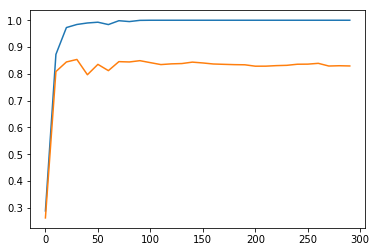

In [9]:
plt.plot(metrics_dict['iteration'], metrics_dict['train_f1'])
plt.plot(metrics_dict['iteration'], metrics_dict['valid_f1'])
plt.show()

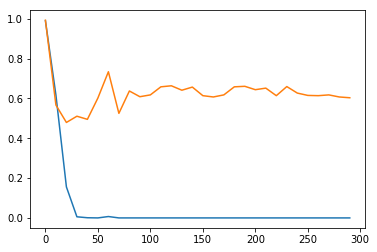

In [10]:
plt.plot(metrics_dict['iteration'], metrics_dict['train_fom'])
plt.plot(metrics_dict['iteration'], metrics_dict['valid_fom'])
plt.show()

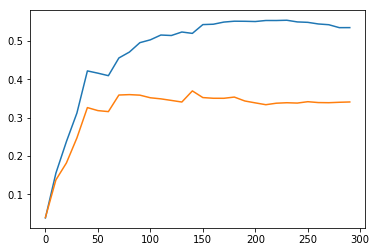

In [11]:
plt.plot(metrics_dict['iteration'], metrics_dict['train_h'])
plt.plot(metrics_dict['iteration'], metrics_dict['valid_h'])
plt.show()

## First Vote Only

In [4]:
data = sio.loadmat('/Users/dwright/dev/zoo/machine_augmented_classification/data/snhunters/3pi_20x20_skew2_signPreserveNorm_volunteer_votes_first_only.mat')
y_train  = np.squeeze(data['y']) == 'Yes'                                                                                       
#y_valid  = np.squeeze(data['y_test']) == 'Yes'                                                                                   
data = sio.loadmat('/Users/dwright/dev/zoo/machine_augmented_classification/data/snhunters/3pi_20x20_skew2_signPreserveNorm.mat')
x_train = data['X']
x_valid = data['testX']
y_valid = np.squeeze(data['testy'])

In [5]:
dec = MultitaskDEC(dims=[x_valid.shape[-1], 500, 500, 2000, 10], \
                   n_clusters=n_clusters, batch_size=batch_size)
dec.initialize_model(optimizer=SGD(lr=lr, momentum=momentum),
                     ae_weights=ae_weights,
                     x=x_train)
dec.model.load_weights(dec_weights)

NameError: name 'MultitaskDEC' is not defined

In [ ]:
y_pred, metrics_dict = dec.clustering(x_train, np_utils.to_categorical(y_train), \
                                      (x_valid, np_utils.to_categorical(y_valid)), \
                                      pretrained_weights=dec_weights, maxiter=maxiter)

In [14]:
data = sio.loadmat('/Users/dwright/dev/zoo/machine_augmented_classification/data/snhunters/3pi_20x20_skew2_signPreserveNorm_volunteer_votes_first_only.mat')
human_f1_benchmark = f1_score(y_valid, np.squeeze(data['y_test']) == 'Yes')
print(human_f1_benchmark)

0.7223326706428097


In [ ]:
plt.plot(metrics_dict['iteration'], metrics_dict['train_f1'])
plt.plot(metrics_dict['iteration'], metrics_dict['valid_f1'])
plt.plot(metrics_dict['iteration'], human_f1_benchmark*np.ones(np.array(metrics_dict['iteration']).shape), 'k--')
plt.show()

In [ ]:
plt.plot(metrics_dict['iteration'], metrics_dict['train_fom'])
plt.plot(metrics_dict['iteration'], metrics_dict['valid_fom'])
plt.show()

In [ ]:
plt.plot(metrics_dict['iteration'], metrics_dict['train_h'])
plt.plot(metrics_dict['iteration'], metrics_dict['valid_h'])
plt.show()

## Vote Fraction Analysis

In [15]:
vote_fraction_dict = pickle.load(open('/Users/dwright/dev/zoo/data/supernova-hunters-vote-fraction-dict.pkl', 'rb'))

In [16]:
train_files = []
for f in data['train_files']:
  train_files.append(f.strip().replace('.fits',''))
print(train_files[0])
#train_files = set(train_files)
print(list(set([i for i in train_files if train_files.count(i)>1])))

1170747061421652300_56452.478_26471976_55_diff
['1001246931044034000_56559.503_28601931_52_diff', '1001246931044034000_56559.515_28603056_68_diff', '1001246931044034000_56559.527_28604731_58_diff', '1001246931044034000_56559.540_28606628_57_diff']


In [17]:
valid_files = []
for f in data['test_files']:
  valid_files.append(f.strip().replace('.fits',''))
print(valid_files[0])
#train_files = set(train_files)
print(list(set([i for i in valid_files if valid_files.count(i)>1])))

1140125671321051200_56734.594_31357137_58_diff
['1001246931044034000_56569.500_28727063_116_diff', '1001246931044034000_56569.512_28729009_121_diff', '1013335101303600300_56578.536_28832078_27_diff', '1013335101303600300_56578.525_28830506_29_diff']


In [18]:
vote_fractions_train = []
vote_fractions_valid = []
seen = []
for diff in train_files:
  vote_fractions_train.append(vote_fraction_dict[diff])
  seen.append(diff)
for diff in valid_files:
  vote_fractions_valid.append(vote_fraction_dict[diff])
print(vote_fractions_train[0])
print(vote_fractions_valid[0])
vote_fractions_train = np.array(vote_fractions_train)
vote_fractions_valid = np.array(vote_fractions_valid)

0.03125
0.6190476190476191


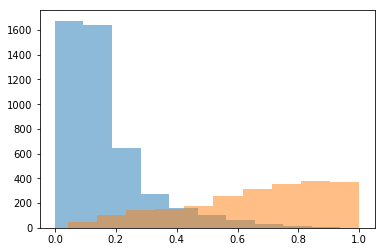

In [19]:
data = sio.loadmat('/Users/dwright/dev/zoo/machine_augmented_classification/data/snhunters/3pi_20x20_skew2_signPreserveNorm.mat')
y_train_true = np.squeeze(data['y'])
bins = [x for x in np.arange(0,1.04,0.04)]
plt.hist(vote_fractions_train[np.where(y_train_true==0)], alpha=0.5)
plt.hist(vote_fractions_train[np.where(y_train_true==1)], alpha=0.5)
plt.show()

In [20]:
y_train_vote_fractions = vote_fractions_train > 0.5
y_valid_vote_fractions = vote_fractions_valid > 0.5

In [21]:
human_vote_fraction_benchmark = f1_score(y_valid, y_valid_vote_fractions)
unavoidable_bias = 1 - f1_score(y_train, y_train_vote_fractions)

In [22]:
one_percent_fpr(y_train, y_train_vote_fractions, 0.01)

(1.0,
 2,
 array([0.        , 0.03514862, 1.        ]),
 array([0.        , 0.73472042, 1.        ]))

In [23]:
dec = MultitaskDEC(dims=[x_valid.shape[-1], 500, 500, 2000, 10], \
                   n_clusters=n_clusters, batch_size=batch_size)
dec.initialize_model(optimizer=SGD(lr=lr, momentum=momentum),
                     ae_weights=ae_weights,
                     x=x_train)
dec.model.load_weights(dec_weights)

In [24]:
cluster_centres = get_cluster_centres(dec)
labels = [str(i) for i in range(n_clusters)]

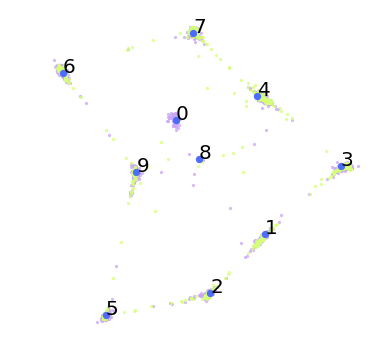

In [25]:
pca_plot(dec.encoder, x_train, cluster_centres, y=y_train, labels=labels, lcolours=[lcolours[0], lcolours[1]])

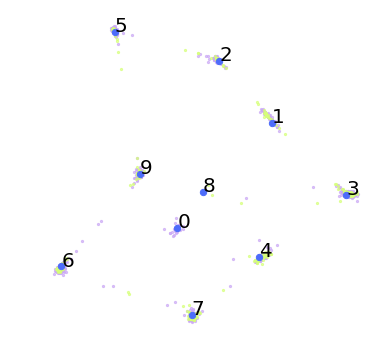

In [26]:
pca_plot(dec.encoder, x_valid, cluster_centres, y=y_valid, labels=labels, lcolours=[lcolours[0], lcolours[1]])

In [27]:
best_mapping_benchmark, _ = get_best_mapping(y_valid, dec.predict_clusters(x_valid), n_clusters, calc_f1_score)

In [28]:
y_pred, metrics_dict = dec.clustering(x_train, np_utils.to_categorical(y_train_vote_fractions), \
                                      (x_valid, np_utils.to_categorical(y_valid)), \
                                      pretrained_weights=dec_weights, maxiter=maxiter, \
                                      alpha=K.variable(1.0), beta=K.variable(0.0), gamma=K.variable(0.0),  \
                                      loss_weight_decay=False, update_interval=10)

Update interval 10
Save interval 135.078125
0 117 0 1.0
1 328 0 0.7652439024390244
2 710 0 0.7507042253521127
3 1069 0 0.7567820392890552
4 365 0 0.6876712328767123
5 1673 0 0.6210400478182905
6 1460 0 0.8397260273972603
7 690 0 0.6898550724637681
8 2 0 1.0
9 502 0 0.7071713147410359
[0. 1.] [0]
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
5
Iter 0  :1% fpr 0.98761 , F1= 0.23834 , F1c= 0.35921 h= 0.03551 nmi= 0.01922 ; loss= [0 0 0] ;
 v 1% fpr=, 0.98303 , vF1= 0.23321 , vF1c= 0.35969 vh= 0.0398 vnmi= 0.02271 ; vloss=, [0.70526 0.70526 0.0681  0.30365]
saving model:  [inf, inf, inf]  ->  [0.70526 0.70526 0.0681  0.30365]
1.0 0.0 0.0
saving model to: ./results/dec/DEC_model_0.h5
1.0 0.0 0.0
1.0 0.0 0.0
1.0 0.0 0.0
1.0 0.0 0.0
1.0 0.0 0.0
1.0 0.0 0.0
1.0 0.0 0.0
1.0 0.0 0.0
1.0 0.0 0.0


/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Iter 10  :1% fpr 0.83037 , F1= 0.80105 , F1c= 0.82002 h= 0.53264 nmi= 0.43654 ; loss= [0.32047 0.32047 3.03496 0.43837] ;
 v 1% fpr=, 0.61097 , vF1= 0.71053 , vF1c= 0.78003 vh= 0.43307 vnmi= 0.35977 ; vloss=, [0.38736 0.38736 0.09422 0.41651]
saving model:  [0.70526 0.70526 0.0681  0.30365]  ->  [0.38736 0.38736 0.09422 0.41651]
1.0 0.0 0.0
1.0 0.0 0.0
1.0 0.0 0.0
1.0 0.0 0.0
1.0 0.0 0.0
1.0 0.0 0.0
1.0 0.0 0.0
1.0 0.0 0.0
1.0 0.0 0.0
1.0 0.0 0.0
Iter 20  :1% fpr 0.49381 , F1= 0.90181 , F1c= 0.88565 h= 0.66855 nmi= 0.58348 ; loss= [0.1829  0.1829  0.30517 0.42696] ;
 v 1% fpr=, 0.87076 , vF1= 0.77571 , vF1c= 0.79238 vh= 0.40895 vnmi= 0.35739 ; vloss=, [0.41563 0.41563 0.09074 0.41559]
1.0 0.0 0.0
1.0 0.0 0.0
1.0 0.0 0.0
1.0 0.0 0.0
1.0 0.0 0.0
1.0 0.0 0.0
1.0 0.0 0.0
1.0 0.0 0.0
1.0 0.0 0.0
1.0 0.0 0.0
Iter 30  :1% fpr 0.37641 , F1= 0.92245 , F1c= 0.91774 h= 0.76134 nmi= 0.65841 ; loss= [0.12604 0.12604 0.25946 0.41477] ;
 v 1% fpr=, 0.71932 , vF1= 0.76369 , vF1c= 0.76879 vh= 0.39686 v

In [28]:
all_ones_benchmark = f1_score(y_valid, np.ones(y_valid.shape))
print(all_ones_benchmark)

0.4991854024112088


In [29]:
avoidable_bias = (1 - metrics_dict['train_f1'][-1]) - unavoidable_bias
bias = unavoidable_bias + avoidable_bias

/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


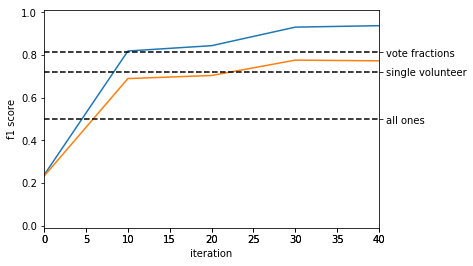

In [30]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(metrics_dict['iteration'], metrics_dict['train_f1'], label='train')
ax1.plot(metrics_dict['iteration'], metrics_dict['valid_f1'], label='validation')
ax1.set_xlim(0,metrics_dict['iteration'][-1])
ax1.set_ylim(-0.01,1.01)
ax1.set_xlabel('iteration')
ax1.set_ylabel('f1 score')

ax2 = fig.add_subplot(111, sharex=ax1, frameon=False)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.plot(metrics_dict['iteration'], human_f1_benchmark*np.ones(np.array(metrics_dict['iteration']).shape), 'k--')
ax2.plot(metrics_dict['iteration'], human_vote_fraction_benchmark*np.ones(np.array(metrics_dict['iteration']).shape), 'k--')
ax2.plot(metrics_dict['iteration'], all_ones_benchmark*np.ones(np.array(metrics_dict['iteration']).shape), 'k--')
ax2.set_xlim(0,metrics_dict['iteration'][-1])
ax2.set_ylim(-0.01,1.01)
ax2.set_yticks([all_ones_benchmark, human_f1_benchmark, human_vote_fraction_benchmark])
ax2.set_yticklabels(['all ones', 'single volunteer', 'vote fractions'])
plt.legend(loc='lower center')
plt.show()

/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


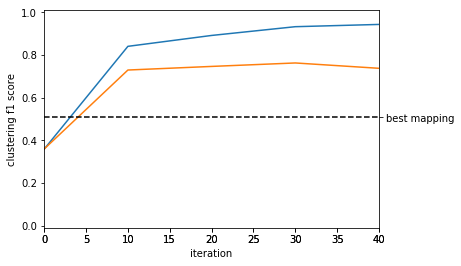

In [31]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(metrics_dict['iteration'], metrics_dict['train_f1c'], label='train')
ax1.plot(metrics_dict['iteration'], metrics_dict['valid_f1c'], label='validation')
ax1.set_xlim(0,metrics_dict['iteration'][-1])
ax1.set_ylim(-0.01,1.01)
ax1.set_xlabel('iteration')
ax1.set_ylabel('clustering f1 score')

ax2 = fig.add_subplot(111, sharex=ax1, frameon=False)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.plot(metrics_dict['iteration'], best_mapping_benchmark*np.ones(np.array(metrics_dict['iteration']).shape), 'k--')
ax2.set_xlim(0,metrics_dict['iteration'][-1])
ax2.set_ylim(-0.01,1.01)
ax2.set_yticks([best_mapping_benchmark])
ax2.set_yticklabels(['best mapping'])
plt.legend(loc='lower center')
plt.show()

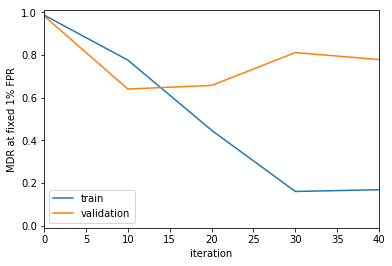

In [32]:
plt.plot(metrics_dict['iteration'], metrics_dict['train_fom'], label='train')
plt.plot(metrics_dict['iteration'], metrics_dict['valid_fom'], label='validation')
plt.xlim(0,metrics_dict['iteration'][-1])
plt.ylim(-0.01,1.01)
plt.xlabel('iteration')
plt.ylabel('MDR at fixed 1% FPR')
plt.legend(loc='lower left')
plt.show()

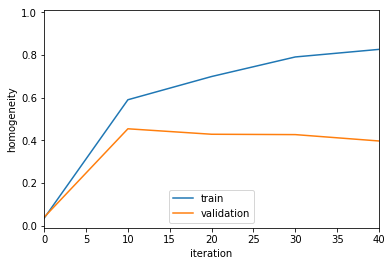

In [33]:
plt.plot(metrics_dict['iteration'], metrics_dict['train_h'], label='train')
plt.plot(metrics_dict['iteration'], metrics_dict['valid_h'], label='validation')
plt.xlim(0,metrics_dict['iteration'][-1])
plt.ylim(-0.01,1.01)
plt.xlabel('iteration')
plt.ylabel('homogeneity')
plt.legend(loc='lower center')
plt.show()

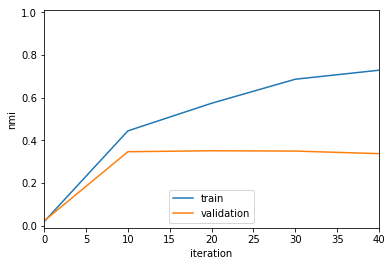

In [34]:
plt.plot(metrics_dict['iteration'], metrics_dict['train_nmi'], label='train')
plt.plot(metrics_dict['iteration'], metrics_dict['valid_nmi'], label='validation')
plt.xlim(0,metrics_dict['iteration'][-1])
plt.ylim(-0.01,1.01)
plt.xlabel('iteration')
plt.ylabel('nmi')
plt.legend(loc='lower center')
plt.show()

In [35]:
cluster_centres = get_cluster_centres(dec)
print(cluster_centres)
labels = [str(i) for i in range(n_clusters)]

[[ 1.1306739  -1.655289    2.0733926  -2.3765278  -0.875512    1.9738472
  -1.9629846   0.24659044  2.082265    2.3592186 ]
 [-1.7717493   2.5832264  -1.7944757   2.6582658   2.7475598   0.40123937
   3.2175567   1.985381    1.1694818   1.1405479 ]
 [-1.5901926  -1.0920275  -2.9530172   3.5749907   2.5699525  -1.266001
   3.0694034   0.74658495 -0.5741602   3.4941716 ]
 [-2.4317276   7.411134    0.59735537  2.326586    3.2154996   2.17575
   3.3579617   3.6148932   2.9893134  -2.4211373 ]
 [-1.4621476   4.1510706   3.141893   -0.25153607  0.15950537  1.153616
  -0.19475055  1.2431815   1.7099178  -3.0265062 ]
 [ 0.8187018  -6.211489   -5.2273073   2.212052    1.2575694  -3.58559
   1.3153456  -1.8189073  -4.356935    2.90652   ]
 [ 2.5579736  -5.4745636   1.3056866  -4.925394   -4.5113916  -1.3146411
  -4.891727   -3.172585   -3.0816793  -2.35075   ]
 [-0.37379152  1.1287268   5.008456   -2.7566051  -2.7947562   1.2843289
  -3.0676463  -0.17278717  1.0935912  -2.9005346 ]
 [ 2.3441522 

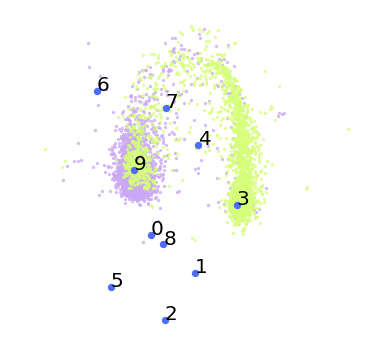

In [36]:
pca_plot(dec.encoder, x_train, cluster_centres, y=y_train, labels=labels, lcolours=[lcolours[0], lcolours[1]])

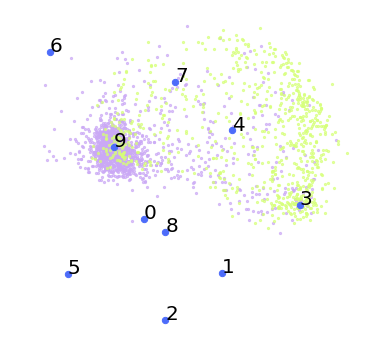

In [37]:
pca_plot(dec.encoder, x_valid, cluster_centres, y=y_valid, labels=labels, lcolours=[lcolours[0], lcolours[1]])

In [38]:
x_all = np.concatenate((x_train, x_valid))
y_all = np.concatenate((y_train, y_valid))

In [153]:
class ReDEC(DEC):
    def clustering(self, train_data, valid_data=None,
                   tol=1e-3,
                   update_interval=140,
                   maxiter=2e4,
                   pretrained_weights=None,
                   save_dir='./results/dec'):
        x = np.concatenate((x_train, x_valid))
        print('Update interval', update_interval)
        save_interval = x.shape[0] / self.batch_size * 5  # 5 epochs
        print('Save interval', save_interval)

        frame_index = 1

        import csv, os
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
          
        metrics_dict = {'iteration':[],
                        'train_f1c':[],
                        'train_h':[],
                        'train_nmi':[],
                        'valid_f1c':[],
                        'valid_h':[],
                        'valid_nmi':[]
                        }
        loss = 0
        index = 0
        for ite in range(int(maxiter)):
            if self.video_path:
                self.model.save_weights(self.video_path+'/%s_%06d_weights.h5'%('clustering', frame_index))
                frame_index += 1

            if ite % update_interval == 0:
                q = self.model.predict(x, verbose=0)
                p = self.target_distribution(q)  # update the auxiliary target distribution p

                # evaluate the clustering performance
                y_pred = q.argmax(1)
                if ite > 0:
                  delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
                y_pred_last = y_pred
                if valid_data is not None:
                  loss = np.round(loss, 5)
                  train_q = q = self.model.predict(train_data[0], verbose=0)
                  train_p = self.target_distribution(train_q)
                  c_map, _, _ = \
                    get_cluster_to_label_mapping_safe(train_data[1], train_q.argmax(1), n_classes, n_clusters, toprint=False)
                  train_cluster_pred = self.model.predict(train_data[0], verbose=0).argmax(1)
                  f1c = np.round(calc_f1_score(train_data[1], train_cluster_pred, c_map), 5)
                  h = np.round(homogeneity_score(train_data[1], train_cluster_pred), 5)
                  nmi = np.round(normalized_mutual_info_score(train_data[1], train_cluster_pred), 5)
                    
                  valid_q = self.model.predict(valid_data[0], verbose=0)
                  valid_p = self.target_distribution(valid_q)
                  val_loss = np.round(self.model.test_on_batch(valid_data[0], valid_p), 5)
                  valid_cluster_pred = valid_q.argmax(1)
                  f1c_valid = np.round(calc_f1_score(valid_data[1], valid_cluster_pred, c_map), 5)
                  h_valid = np.round(homogeneity_score(valid_data[1], valid_cluster_pred), 5)
                  nmi_valid = np.round(normalized_mutual_info_score(valid_data[1], valid_cluster_pred), 5)

                  print('Iter', ite,', F1c=', f1c, 'h=', h, 'nmi=', nmi, '; loss=', loss, ';', \
                        'vF1c=', f1c_valid,'vh=', h_valid, 'vnmi=', nmi_valid, '; vloss=,', val_loss)
                  metrics_dict['iteration'].append(ite)
                  metrics_dict['train_f1c'].append(f1c)
                  metrics_dict['train_h'].append(h)
                  metrics_dict['train_nmi'].append(nmi)
                  metrics_dict['valid_f1c'].append(f1c_valid)
                  metrics_dict['valid_h'].append(h_valid)
                  metrics_dict['valid_nmi'].append(nmi_valid)
                # check stop criterion
                if ite > 0 and delta_label < tol:
                    print('delta_label ', delta_label, '< tol ', tol)
                    print('Reached tolerance threshold. Stopping training.')
                    break

            # train on batch
            if (index + 1) * self.batch_size > x.shape[0]:
                loss = self.model.train_on_batch(x=x[index * self.batch_size::],
                                                 y=p[index * self.batch_size::])
                index = 0
            else:
                loss = self.model.train_on_batch(x=x[index * self.batch_size:(index + 1) * self.batch_size],
                                                 y=p[index * self.batch_size:(index + 1) * self.batch_size])
                index += 1

            # save intermediate model
            if ite % save_interval == 0:
                # save IDEC model checkpoints
                print('saving model to:', save_dir + '/DEC_model_' + str(ite) + '.h5')
                self.model.save_weights(save_dir + '/DEC_model_' + str(ite) + '.h5')

            ite += 1

        # save the trained model
        print('saving model to:', save_dir + '/DEC_model_final.h5')
        self.model.save_weights(save_dir + '/DEC_model_final.h5')

        return y_pred, metrics_dict

In [154]:
redec = ReDEC(dims=[x_valid.shape[-1], 500, 500, 2000, 10], \
                   n_clusters=n_clusters, batch_size=batch_size)
redec.initialize_model(optimizer=SGD(lr=lr, momentum=momentum),
                     ae_weights=ae_weights,
                     x=x_train)
redec.model.load_weights(dec_weights)

In [155]:
dec.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 10)           1473010     input_1[0][0]                    
__________________________________________________________________________________________________
clustering (ClusteringLayer)    (None, 10)           100         model_2[1][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 2)            22          clustering[0][0]                 
__________________________________________________________________________________________________
model_1 (M

In [156]:
dec.model.layers[1]

In [157]:
for i in range(1,len(dec.model.layers[1].layers)):
    redec.model.layers[i].set_weights(dec.model.layers[1].layers[i].get_weights())
redec.model.layers[-1].set_weights(dec.model.layers[2].get_weights())

In [158]:
y_pred, metrics_dict = redec.clustering((x_train, y_train), (x_valid, y_valid), pretrained_weights=None, maxiter=2e4, update_interval=140)

Update interval 140
Save interval 180.05859375


/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Iter 0 , F1c= 0.83896 h= 0.49204 nmi= 0.45316 ; loss= 0 ; vF1c= 0.77962 vh= 0.38264 vnmi= 0.31863 ; vloss=, 0.09146
saving model to: ./results/dec/DEC_model_0.h5
Iter 140 , F1c= 0.84153 h= 0.49572 nmi= 0.44114 ; loss= 0.08525 ; vF1c= 0.77931 vh= 0.38331 vnmi= 0.3088 ; vloss=, 0.10114
Iter 280 , F1c= 0.84493 h= 0.50229 nmi= 0.43125 ; loss= 0.05144 ; vF1c= 0.78391 vh= 0.39114 vnmi= 0.3045 ; vloss=, 0.10873
Iter 420 , F1c= 0.84477 h= 0.50461 nmi= 0.411 ; loss= 0.0647 ; vF1c= 0.79482 vh= 0.41029 vnmi= 0.30796 ; vloss=, 0.11706
Iter 560 , F1c= 0.84434 h= 0.50782 nmi= 0.39487 ; loss= 0.07343 ; vF1c= 0.80545 vh= 0.42914 vnmi= 0.30794 ; vloss=, 0.12529
Iter 700 , F1c= 0.83824 h= 0.5135 nmi= 0.38241 ; loss= 0.09881 ; vF1c= 0.7907 vh= 0.43013 vnmi= 0.29733 ; vloss=, 0.13077
Iter 840 , F1c= 0.83867 h= 0.51834 nmi= 0.37296 ; loss= 0.09569 ; vF1c= 0.78873 vh= 0.43234 vnmi= 0.28988 ; vloss=, 0.13168
Iter 980 , F1c= 0.84003 h= 0.52274 nmi= 0.36608 ; loss= 0.09193 ; vF1c= 0.78495 vh= 0.43047 vnmi= 0.2

[[ 7.42788911e-01 -1.31579697e+00  2.20745206e+00 -2.17030001e+00
  -1.19956803e+00  1.46283913e+00 -1.98102856e+00 -3.98328202e-03
   1.49067962e+00  1.34563684e+00]
 [-2.06436300e+00  3.24004388e+00 -1.86707056e+00  3.37686491e+00
   3.47801304e+00  5.02524137e-01  3.80922413e+00  2.41367340e+00
   1.41977334e+00  1.26839900e+00]
 [-1.18693054e+00 -1.16080546e+00 -3.66150260e+00  3.36766052e+00
   2.80220699e+00 -1.21648037e+00  3.17907000e+00  7.60343671e-01
  -7.35365033e-01  3.41563559e+00]
 [-3.37767100e+00  9.33662987e+00  9.39668059e-01  3.29826832e+00
   4.12347412e+00  2.54510570e+00  4.41209078e+00  4.51071405e+00
   3.90895224e+00 -2.63659477e+00]
 [-1.79822767e+00  5.56650639e+00  4.06260920e+00 -5.06448030e-01
   1.19059965e-01  2.12108707e+00 -1.08530819e-01  2.03210378e+00
   2.67992067e+00 -3.56801271e+00]
 [ 8.91740143e-01 -7.38951683e+00 -6.59897518e+00  2.58002806e+00
   1.50920177e+00 -4.27732277e+00  1.74186957e+00 -2.07617259e+00
  -5.20667648e+00  3.71729398e+00

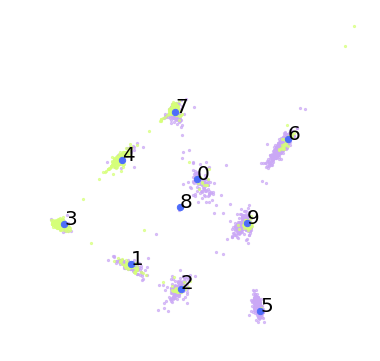

In [159]:
cluster_centres = get_cluster_centres(redec)
print(cluster_centres)
labels = [str(i) for i in range(n_clusters)]
pca_plot(redec.encoder, x_train, cluster_centres, y=y_train, labels=labels, lcolours=[lcolours[0], lcolours[1]])

In [160]:
get_cluster_to_label_mapping_safe(y_all, y_pred, n_classes, n_clusters, toprint=True)

0 167 0 0.8922155688622755
1 435 0 0.7195402298850575
2 387 0 0.9018087855297158
3 1821 1 0.8923668314113125
4 773 1 0.8602846054333765
5 768 0 0.9973958333333334
6 998 0 0.9529058116232465
7 743 0 0.5612382234185733
8 0 0 nan
9 3127 0 0.9264470738727214
[0. 1.] [0 1]
[0, 0, 0, 1, 1, 0, 0, 0, 0, 0]


/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


([0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
 [167, 435, 387, 1821, 773, 768, 998, 743, 0, 3127],
 [0.8922155688622755,
  0.7195402298850575,
  0.9018087855297158,
  0.8923668314113125,
  0.8602846054333765,
  0.9973958333333334,
  0.9529058116232465,
  0.5612382234185733,
  nan,
  0.9264470738727214])